# **Codigo Capitulo 10**

# **Entrenamiento de modelo con imagenes de Webots**

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import os


c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_data = pd.read_csv('image_data.csv')
print(image_data.shape)
print(image_data['Image Name'].nunique())
image_data['image_path'] = './train_images/' + image_data['Image Name']
image_paths_wb = image_data['image_path'].values
steerings_wb = image_data['Angle'].values
image_data.head()

(29227, 3)
29227


,Image Name,Angle,Wheel angle,image_path
0,2024-06-21 21-37-38-675791.png,0.0,0,./train_images/2024-06-21 21-37-38-675791.png
1,2024-06-21 21-37-38-780698.png,0.0,0,./train_images/2024-06-21 21-37-38-780698.png
2,2024-06-21 21-37-38-887095.png,0.0,0,./train_images/2024-06-21 21-37-38-887095.png
3,2024-06-21 21-37-39-003226.png,0.0,0,./train_images/2024-06-21 21-37-39-003226.png
4,2024-06-21 21-37-39-108620.png,0.0,0,./train_images/2024-06-21 21-37-39-108620.png


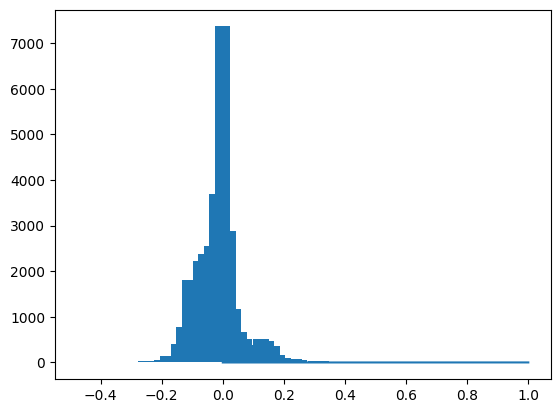

In [3]:
num_bins = 50
hist, bins = np.histogram(image_data['Angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(image_data['Angle']), np.max(image_data['Angle'])))

In [4]:
def calculate_sampling_probability(angle):
    return np.abs(angle) + 0.01  # Añadir un pequeño valor para que 0 tenga una probabilidad mayor a 0

# Calcular las probabilidades
image_data['sampling_prob'] = image_data['Angle'].apply(calculate_sampling_probability)

# Normalizar las probabilidades para que sumen 1
total_prob = image_data['sampling_prob'].sum()
image_data['sampling_prob'] /= total_prob

# Realizar el muestreo basado en las probabilidades calculadas
sampled_df = image_data.sample(frac=0.3, weights='sampling_prob', random_state=1)


# Si quieres remover la columna de probabilidades luego del muestreo
sampled_df = sampled_df.drop(columns=['sampling_prob'])

# Resetear el índice del DataFrame resultante si es necesario
sampled_df = sampled_df.reset_index(drop=True)

In [5]:
image_data = sampled_df

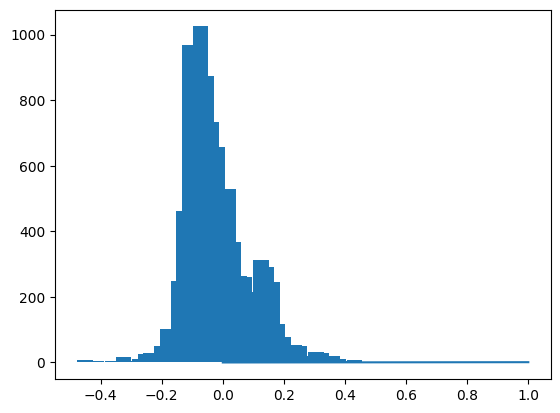

In [6]:
num_bins = 50
hist, bins = np.histogram(image_data['Angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(image_data['Angle']), np.max(image_data['Angle'])))

In [7]:
image_paths_wb = image_data['image_path'].values
steerings_wb = image_data['Angle'].values
print(image_paths_wb.shape)
print(steerings_wb.shape )

(8768,)
(8768,)


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths_wb, steerings_wb, test_size=0.2, random_state=6, shuffle=True)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 7014
Valid Samples: 1754


Text(0.5, 1.0, 'Validation set')

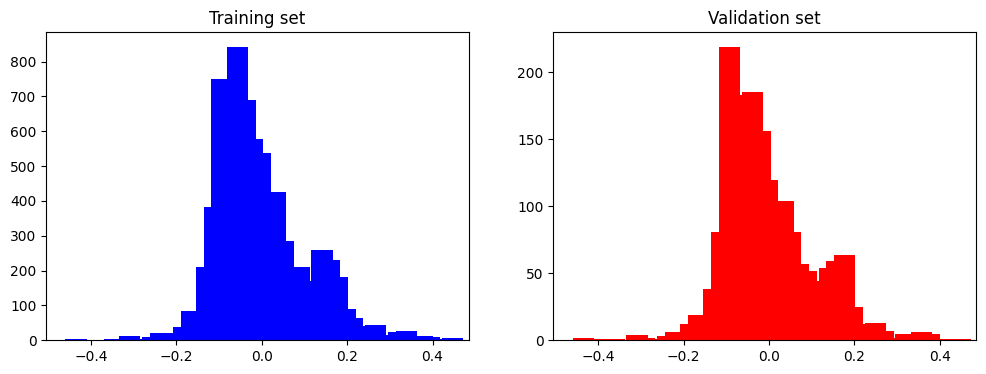

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [10]:

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = - steering_angle
    return image, steering_angle


def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

# def img_preprocess(img):
#     img = img[60:135,:,:]
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#     img = cv2.GaussianBlur(img, (3, 3), 0)
#     img = cv2.resize(img, (200, 66))
#     img = img/255
#     return img

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.08')

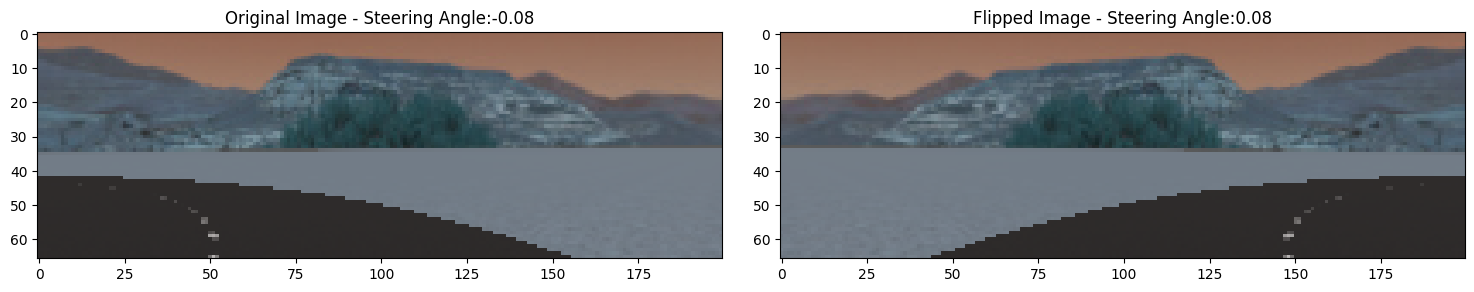

In [11]:
random_index = random.randint(0, 1000)
image = image_paths_wb[random_index]
steering_angle = steerings_wb[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

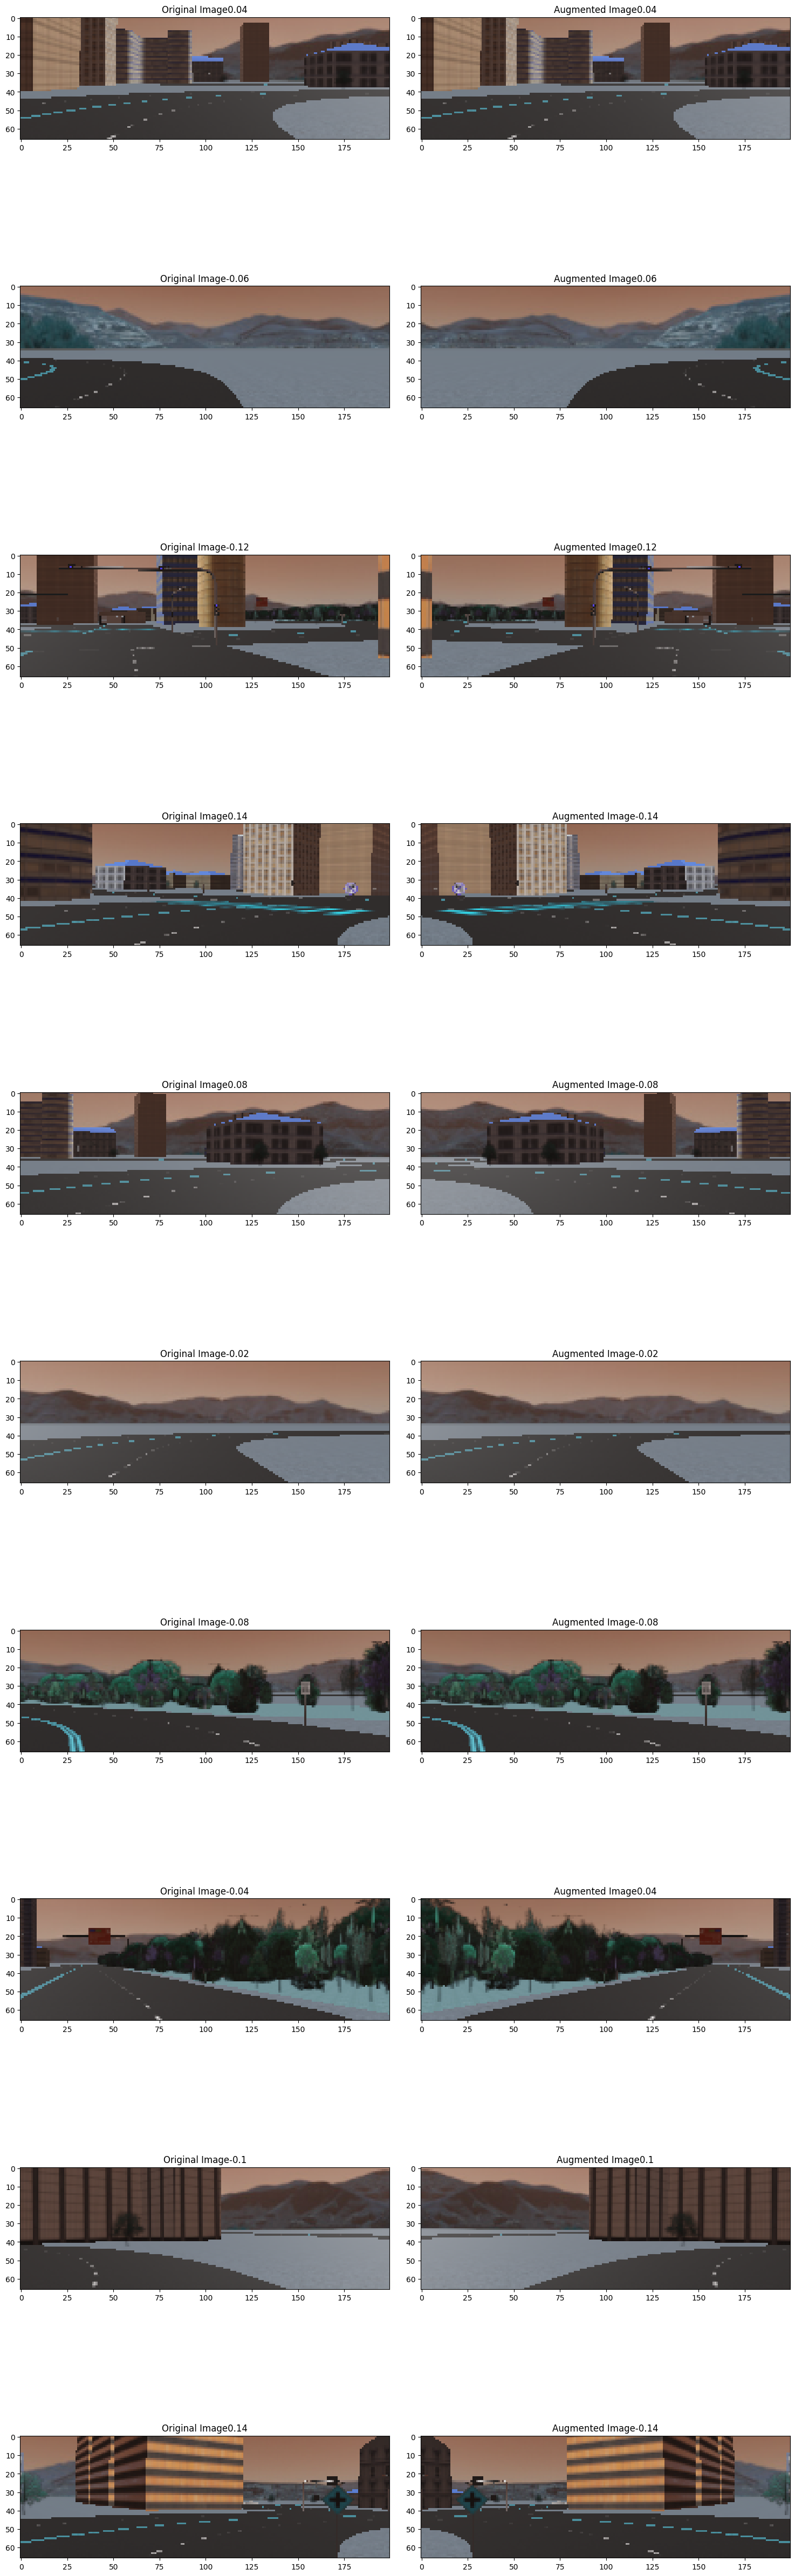

In [12]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths_wb) - 1)
    random_image = image_paths_wb[randnum]
    random_steering = steerings_wb[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image" + str(random_steering))

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image" + str(steering))

In [13]:
def batch_generator_wb(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            # im = img_preprocess_webots(im)
            # print(im.shape)

            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 4), activation='elu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=optimizer)

c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         2,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,819 (987.57 KB)

 Trainable params: 252,819 (987.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=10,          # Número de épocas de paciencia
    restore_best_weights=False  # Restaura los pesos del modelo a la mejor época
)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = scaler.transform(y_valid.reshape(-1, 1))

In [18]:
history = model.fit(batch_generator_wb(X_train, y_train_scaled, int(len(y_train_scaled)), False),
                              steps_per_epoch=5,
                              epochs=100,
                              validation_data=batch_generator_wb(X_valid, y_valid_scaled, int(len(y_valid_scaled)), False),
                              validation_steps=5,
                              verbose=1,
                              shuffle = 1,
                    callbacks=[early_stopping])

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 13s/step - loss: 1.0194 - val_loss: 0.0210
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 75s 18s/step - loss: 0.0547 - val_loss: 0.0782
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 67s 14s/step - loss: 0.0493 - val_loss: 0.0135
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - loss: 0.0212 - val_loss: 0.0130
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - loss: 0.0180 - val_loss: 0.0121
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - loss: 0.0146 - val_loss: 0.0114
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - loss: 0.0131 - val_loss: 0.0115
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - loss: 0.0119 - val_loss: 0.0114
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - loss: 0.0110 - val_loss: 0.0108
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - loss: 0.0106 - val_loss: 0.0095
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - loss: 0.0099 - val_loss: 0.0094
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - loss: 0.0091 - val_loss: 0.009

Text(0.5, 0, 'Epoch')

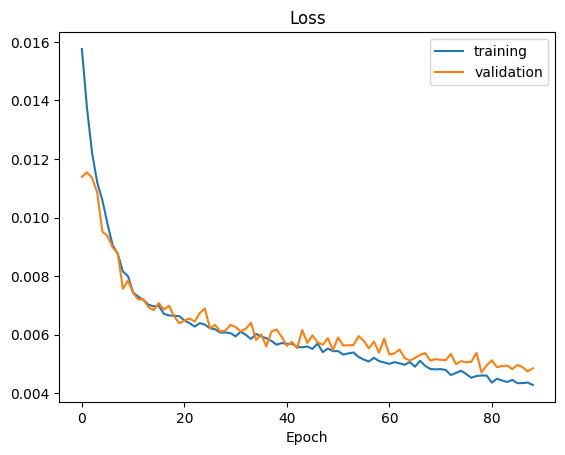

In [19]:
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [20]:
model.save('model_project_without_preprocessing.h5')

In [51]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [24]:
X_train[0]

'./train_images/2024-06-21 22-36-12-151675.png'

In [25]:
image = mpimg.imread(r'./train_images\2024-06-21 21-37-38-675791.png')

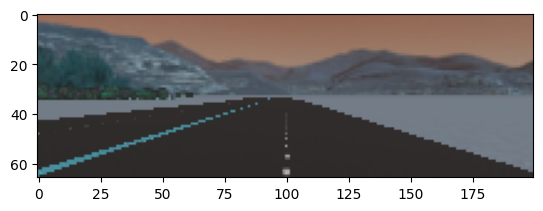

In [26]:
plt.imshow(image)

In [27]:
predicted_angle = model.predict(np.expand_dims(image, axis=0))
predicted_angle

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


array([[0.5676217]], dtype=float32)

In [28]:
predicted_angle_1 = scaler.inverse_transform(predicted_angle)
predicted_angle_1

array([[0.05085954]], dtype=float32)

In [35]:
from PIL import Image
# Cargar la imagen desde el disco
image_pil = Image.open(r'./train_images\2024-06-21 17-37-12-791569.png')

# Convertir la imagen a un arreglo NumPy
image_np = np.array(image_pil)

In [36]:
image_np.shape

(66, 200, 4)

In [37]:
predicted_angle = model.predict(np.expand_dims(image_np/255, axis=0))
predicted_angle

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.546973]], dtype=float32)

In [38]:
predicted_angle_1 = scaler.inverse_transform(predicted_angle)
predicted_angle_1

array([[0.0234865]], dtype=float32)